### Clustering Popular Goodreads Books

In this notebook, we'll use NLP and clustering techniques in order to explore potentail groupings of the most reviewd books from Goodreads.

Original 10k Goodreads Book Dataset:https://github.com/zygmuntz/goodbooks-10k

10k-Enriched Dataset: https://github.com/malcolmosh/goodbooks-10k-extended

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import os

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

# download tokenizer info
nltk.download('punkt')
# download lemmatizer info
nltk.download('wordnet')
# download stopwords
nltk.download('stopwords')

nltk.download('omw-1.4')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics


# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
!pip install umap-learn
import umap


# Clustering Models
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install WordCloud
from wordcloud import WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load the original and enriched versions of the dataset

books = pd.read_csv('https://github.com/zygmuntz/goodbooks-10k/releases/download/v1.0/books.zip')
books_enriched = pd.read_csv('https://raw.githubusercontent.com/malcolmosh/goodbooks-10k/master/books_enriched.csv')
right_columns = books_enriched.columns.difference(books.columns).append(pd.Index(['book_id']))

# merge the two keeping only unique columns
df = books.merge(books_enriched[right_columns], how='outer', on='book_id', suffixes=('','')).copy()

In [ ]:
# drop any book that isn't labeled with an English language code
df = df[df['language_code'].isin(['eng', 'en-US', 'en-GB', 'en-CA', 'en'])]

In [ ]:
# pare down the dataframe to just the appropriate columns
df = pd.DataFrame(df[['book_id', 'original_title','description']].copy())

df.dropna(inplace=True)

df.head()

,book_id,original_title,description
0,1,The Hunger Games,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...
1,2,Harry Potter and the Philosopher's Stone,Harry Potter's life is miserable. His parents ...
2,3,Twilight,About three things I was absolutely positive.\...
3,4,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...
4,5,The Great Gatsby,Alternate Cover Edition ISBN: 0743273567 (ISBN...


In [ ]:
# remove non alphabet characters
df['description'] = df['description'].str.replace(r'[^a-zA-Z]', ' ', regex=True)

#apply tokenizer
df['description'] = df['description'].apply(word_tokenize)

ps = PorterStemmer()
df['description'] = df['description'].apply(lambda row: [ps.stem(word) for word in row])

lemmatizer = WordNetLemmatizer()
df['description'] = df['description'].apply(lambda row:[lemmatizer.lemmatize(word) for word in row])

df['description'] = df['description'].apply(lambda word: ' '.join(word))


df.head()

,book_id,original_title,description
0,1,The Hunger Games,win mean fame and fortun lose mean certain dea...
1,2,Harry Potter and the Philosopher's Stone,harri potter s life is miser hi parent are dea...
2,3,Twilight,about three thing i wa absolut posit first edw...
3,4,To Kill a Mockingbird,the unforgett novel of a childhood in a sleepi...
4,5,The Great Gatsby,altern cover edit isbn isbn the great gatsbi f...


We'll use a simple bag-of-words representation of our book descriptions.

In [ ]:
max_words = 10000

cv = TfidfVectorizer(max_features=max_words, stop_words='english')

matrix = cv.fit_transform(df['description']).toarray()

In [ ]:
# concatenate descriptions and tokenize into words
descriptions = df['description'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(descriptions)

# filter out English stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [w for w in words if not w in stop_words]

# get the frequency of words and sort by the most common
word_dist = nltk.FreqDist(filtered_words)
word_dist = {k: v for k, v in sorted(word_dist.items(), key=lambda item: item[1], reverse=True)}


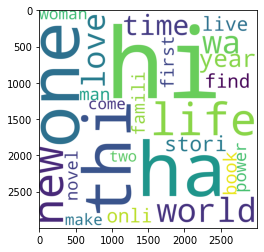

In [ ]:
wc = WordCloud(background_color="white",width=3000,height=3000, max_words=25,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(word_dist)
plt.imshow(wc)
plt.show()


In [ ]:
for k, v in list(word_dist.items())[:10]:
    print(k, v)

hi 11743
ha 6270
one 5506
thi 4754
life 4366
new 4153
world 3753
wa 3541
love 3387
time 3235


From our list of most common words in the initial descriptions include some words you would expect when describing dramatic stories like live, love, and world.

## Dimensionality Reduction

We'll now run through some algorithms to assess the best approach for dimenstion reduction.

In [ ]:
df_cv = pd.DataFrame(matrix)
print(df_cv.shape)

(8204, 10000)


In [ ]:
pca = PCA(n_components = 4)
pca_components = pca.fit_transform(df_cv)

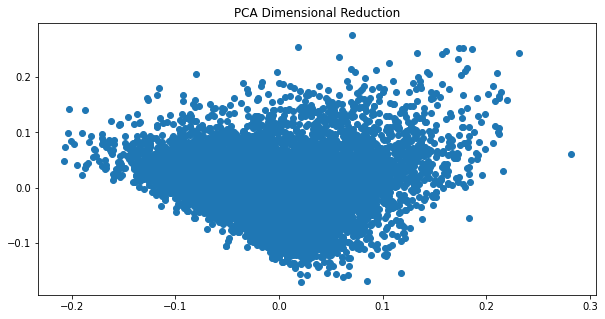

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
#plt.xticks([])
#plt.yticks([])
plt.axis('on')
plt.title('PCA Dimensional Reduction')
plt.show()

The two dimensional PCA composition does not lend itself to any clear clusters. It's a tight cloud that slowly dissapates around the edges.

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250)
tsne_results = tsne.fit_transform(df_cv)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8204 samples in 0.061s...
[t-SNE] Computed neighbors for 8204 samples in 20.346s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8204
[t-SNE] Computed conditional probabilities for sample 2000 / 8204
[t-SNE] Computed conditional probabilities for sample 3000 / 8204
[t-SNE] Computed conditional probabilities for sample 4000 / 8204
[t-SNE] Computed conditional probabilities for sample 5000 / 8204
[t-SNE] Computed conditional probabilities for sample 6000 / 8204
[t-SNE] Computed conditional probabilities for sample 7000 / 8204
[t-SNE] Computed conditional probabilities for sample 8000 / 8204
[t-SNE] Computed conditional probabilities for sample 8204 / 8204
[t-SNE] Mean sigma: 0.485570
[t-SNE] KL divergence after 250 iterations with early exaggeration: 162.351410
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953

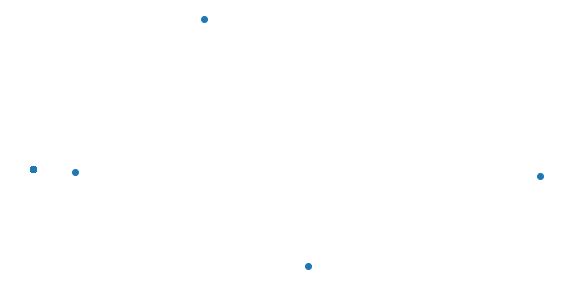

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

t-SNE has also created a singular shape with a very small number of outliers.

In [ ]:
umap_results = umap.UMAP(n_neighbors=20, 
                         min_dist=0.2, 
                         metric='correlation').fit_transform(df_cv)

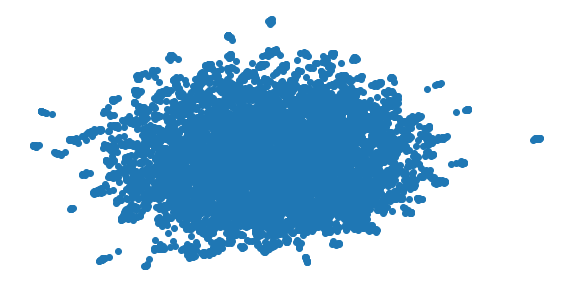

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

The Umap results look more promising for finding a few different clusters, There's still a distinct group where most of our books lie, but now there are a couple of groups outside of it. This shows promise for finding books that our outlier to the norm.

## Clustering Aglorithms

We will now use the Umap results to identify and explore some of the outlying books and try to determine what makes their discriptions different.

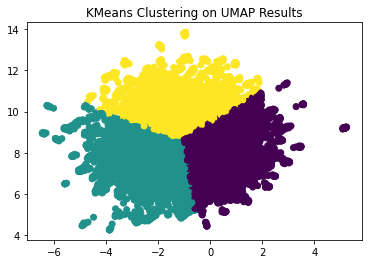

The silhouette score of the KMeans solution: 0.34957826137542725


In [ ]:
# KMeans Clustering

mini_batch_k_means = MiniBatchKMeans(n_clusters = 3)
mini_batch_k_means.fit(umap_results)
k_means_predict = mini_batch_k_means.predict(umap_results)

plt.scatter(umap_results[:, 0], umap_results[:, 1], c=k_means_predict)
plt.title('KMeans Clustering on UMAP Results')
plt.show()

print("The silhouette score of the KMeans solution: {}"
      .format(metrics.silhouette_score(umap_results, k_means_predict, metric='euclidean')))


Out central blob is not linearly separable so K-means will not help us.

In [ ]:
dbscan_cluster = DBSCAN(eps=0.2, min_samples=5)
clusters = dbscan_cluster.fit_predict(umap_results)

print('Found {} clusters.'.format(max(clusters)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(umap_results, clusters, metric='euclidean')))

Found 34 clusters.
The silhouette score of the DBSCAN solution: -0.2496422380208969


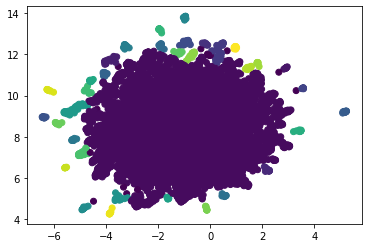

In [ ]:
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=clusters)
plt.show()


Visually, DBSCAN looks to identify some clusters outliying the main one. This has the affect of making our silhouette score negative as a large proportion of the main cluster points end up closer to these edge clusters.

Lets investigate some of the books that look like they're outside the "zero" cluster

## Outside the Main Cluster

In [ ]:
df['cluster'] = clusters
df.head()

,book_id,original_title,description,cluster
0,1,The Hunger Games,win mean fame and fortun lose mean certain dea...,0
1,2,Harry Potter and the Philosopher's Stone,harri potter s life is miser hi parent are dea...,0
2,3,Twilight,about three thing i wa absolut posit first edw...,0
3,4,To Kill a Mockingbird,the unforgett novel of a childhood in a sleepi...,0
4,5,The Great Gatsby,altern cover edit isbn isbn the great gatsbi f...,0


In [ ]:
outliers = df[df['cluster'] != 0]
outliers = df.merge(outliers[['book_id']], how='inner', on='book_id').copy()

outliers.head()

,book_id,original_title,description,cluster
0,35,O Alquimista,paulo coelho s masterpiec tell the mystic stor...,1
1,51,City of Bones,when fifteen year old clari fray head out to t...,2
2,60,The Curious Incident of the Dog in the Night-Time,christoph john franci boon know all the countr...,3
3,83,A Tale of Two Cities,after eighteen year a a polit prison in the ba...,23
4,108,Confessions of a Shopaholic,becki bloomwood ha a fabul flat in london s tr...,4


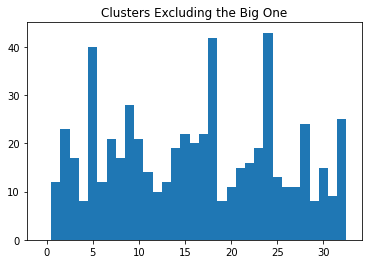

In [ ]:
plt.hist(outliers['cluster'], bins=range(outliers['cluster'].max()), align='left')
plt.title('Clusters Excluding the Big One')
plt.show()

All of these clusters contain less than a hundered members. We'll look to see which one's have the most members and then take a deeper dive on each.

In [ ]:
outliers['cluster'].value_counts().sort_values(ascending=False).head()

24    43
18    42
5     40
9     28
28    24
Name: cluster, dtype: int64

Clusters 24, 18, and 5 have the most members. Lets take a look at the most common words and some sample books from each.

In [ ]:
# function to simplify making the wordcloud for each cluster
def outlier_wordcloud(cluster):
    cluster_ids = outliers[outliers['cluster'] == cluster]['book_id'].to_list()
    cluster_df = df[df['book_id'].isin(cluster_ids)].copy()
    
    word_dist = get_word_dist(cluster_df)

    wc = WordCloud(background_color="white",width=3000,height=3000, max_words=25,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(word_dist)
    plt.imshow(wc)
    
# function to get the word frequencies from the descriptions of the cluster descriptions
def get_word_dist(cluster_df):

    # concatenate descriptions and tokenize into words
    descriptions = cluster_df['description'].str.cat(sep=' ')
    words = nltk.tokenize.word_tokenize(descriptions)

    # filter out English stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [w for w in words if not w in stop_words]

    # get the frequency of words and sort by the most common
    word_dist = nltk.FreqDist(filtered_words)
    word_dist = {k: v for k, v in sorted(word_dist.items(), key=lambda item: item[1], reverse=True)}

    
    return word_dist

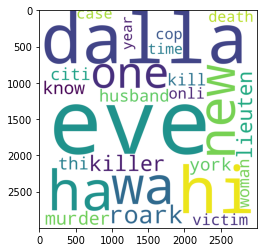

In [ ]:
outlier_wordcloud(24)

In [ ]:
outliers[outliers['cluster'] == 24].sample(n=10, random_state = 42)

,book_id,original_title,description,cluster
569,8822,Concealed in Death,in a decrepit long empti new york build lieute...,24
509,7633,"Born in Death (In Death, #23)",eve dalla ha a grisli doubl homicid to solv wh...,24
520,7911,"Divided in Death (In Death, #18)",reva ewe a former member of the secret servic ...,24
566,8785,Thankless in Death,in the latest suspens thriller in the new york...,24
553,8615,Celebrity in Death,lieuten eve dalla is no parti girl but she s m...,24
593,9528,Obsession in Death,there s a thin line between hero worship and d...,24
307,4423,Immortal in Death,when polic lieuten eve dalla investig the murd...,24
419,6325,Memory in Death,the new york time bestsel author of survivor i...,24
358,5340,Vengeance in Death,he is an expert with the latest technolog a ma...,24
295,4134,The Killing Game,a merciless killer on the hunt an innoc child ...,24


We've identified a cluster containing Nora Rober's "In Death" series owing to the names of the characters in the book descriptions.

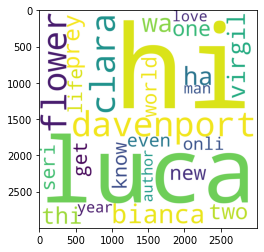

In [ ]:
outlier_wordcloud(18)

In [ ]:
outliers[outliers['cluster'] == 18].sample(n=10, random_state = 42)

,book_id,original_title,description,cluster
411,6185,Secret Prey,the compani chairman lay dead in the wood hi o...,18
218,2918,What She Left Behind,in thi stun new novel the acclaim author of th...,18
168,2217,Hallowed,for month clara gardner train to face the fire...,18
435,6561,Eyes of Prey,lieuten davenport s saniti wa nearli shatter b...,18
95,1276,Unearthly,in the begin there s a boy stand in the tree c...,18
589,9468,Mortal Prey,year ago luca davenport almost die at the hand...,18
339,5109,Chosen Prey,against the unforgett backdrop of new york nea...,18
528,8133,Certain Prey,attorney carmel loan is beauti intellig ambiti...,18
537,8315,The Mermaid's Sister,winner amazon breakthrough novel award young a...,18
161,2134,Evernight,bianca want to escap she s been uproot from he...,18


Another police detective series. This one by John Sanford.

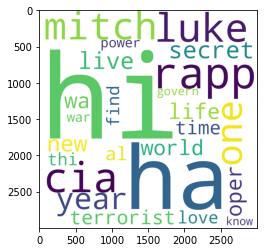

In [ ]:
outlier_wordcloud(5)

In [ ]:
outliers[outliers['cluster'] == 5].sample(n=10, random_state = 42)

,book_id,original_title,description,cluster
248,3422,Come Away with Me,an altern cover edit can be found here be conf...,5
233,3167,Executive Power,cia superag mitch rapp battl global terror in ...,5
220,2964,Kill Shot,new york time bestsel author of american assas...,5
372,5541,"Among the Impostors (Shadow Children, #2)",luke garner is terrifi out of hide for the fir...,5
80,1098,The Longest Ride,ira levinson is in troubl at nineti one year o...,5
213,2830,Consent to Kill,for year mitch rapp s bold action have save th...,5
546,8535,Star Wars: From the Adventures of Luke Skywalker,luke skywalk challeng the stormtroop of a dist...,5
393,5852,The Mothers,set within a contemporari black commun in sout...,5
598,9614,The Faithful Spy,john well penetr al qaeda for ten year until o...,5
113,1573,A Painted House,the hill peopl and the mexican arriv on the sa...,5


This cluster has a number of "Mitch Rapp" series about a CIA operative in the middle east.


## Potential Improvements

The bag-of-words did not provide particluarly illuminating results. Our most interesting clusters consisted of books from the most frequently reviews series on Goodreads. Futher inspection of our "outlier" clusters would likely show similar results.

Further refinements to the dimensionality reduction. The distribution of the data with UMap was most promising but the coustering methods were less than ideal for differnt reasons. KMeans gave us a silhouette score of 0.3496 but did not meet the isotropic assumptions of KMeans. A kernel trick may help our central blob to become more linearly separable. DBSCAN was able to identify the central cluster but the silhouette score was -0.2496. Not a strong case for meaninful clusters. The main reason I used the DBSCAN was KMeans failure to linearly separate the data.

Some improvements on the NLP pipeline could be made with word embeddings as some similar words are still being counted differently. Bi and trigrams might also help us to find some separation between our books.